# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial

np.set_printoptions(suppress=True)

In [4]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

In [47]:
from initializations import initialize_agents, initialize_beacons
from simulations import motion_simulation

from priors import complete_pooling_prior

## Initializations

First, we need to initialize some agents and some beacons.

In [48]:
agent_positions, agent_rotations = initialize_agents()
beacon_positions = initialize_beacons()
agent_rotations.shape

(12, 1)

## Influences

There are 4 influence vectors to an agent:
* **Positional influence** (individual): drift-diffusion process for agent displacement (locomotion);
* **Rotational influence** (individual): drift-diffusion process for agent orientation (head movement);
* **Cohesion influence** (collective): active particle dynamics for agent position following;
* **Alignment influence** (collective): active particle dynamics for agent orientation following.

The implementation of all influences can be found in the `influences` module. Implemented simulations based on the individual influences and their respective combinations based on their categories can be found in the `simulations` module.

## Final simulation

Combining all influences yields the final simulation.

In [49]:
# At the room's maximum occupancy
sim = motion_simulation(num_agents=49, num_beacons=25)

In [50]:
simulator = Simulator(simulator_fun=partial(motion_simulation, timesteps=1001))

# Priors

In [51]:
param_names = [r"$w_a$", r"$r_a$", r"$v_a$"]

In [52]:
prior = Prior(prior_fun=complete_pooling_prior, param_names=param_names)

## Checks

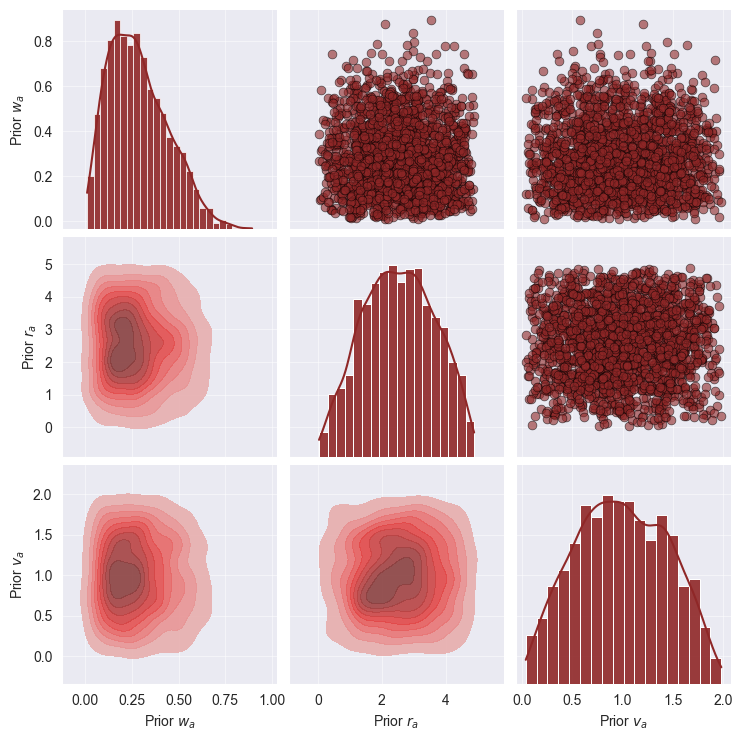

In [38]:
pp_checks = prior.plot_prior2d()

## Generative model

In [53]:
model = GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False,
    name="tflow"
)

INFO:root:Performing 2 pilot runs with the tflow model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1001, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


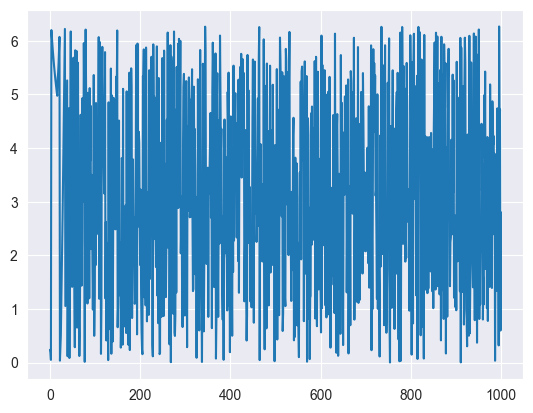

In [59]:
import matplotlib.pyplot as plt

sim = model(5)
test_sim = sim['sim_data'][2]
plt.plot(test_sim[:,0,-1])

# Configurator

In [60]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [61]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)

amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

# Training

In [62]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Training

To make sure that the model is trainable.

In [63]:
losses = trainer.train_online(epochs=1, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

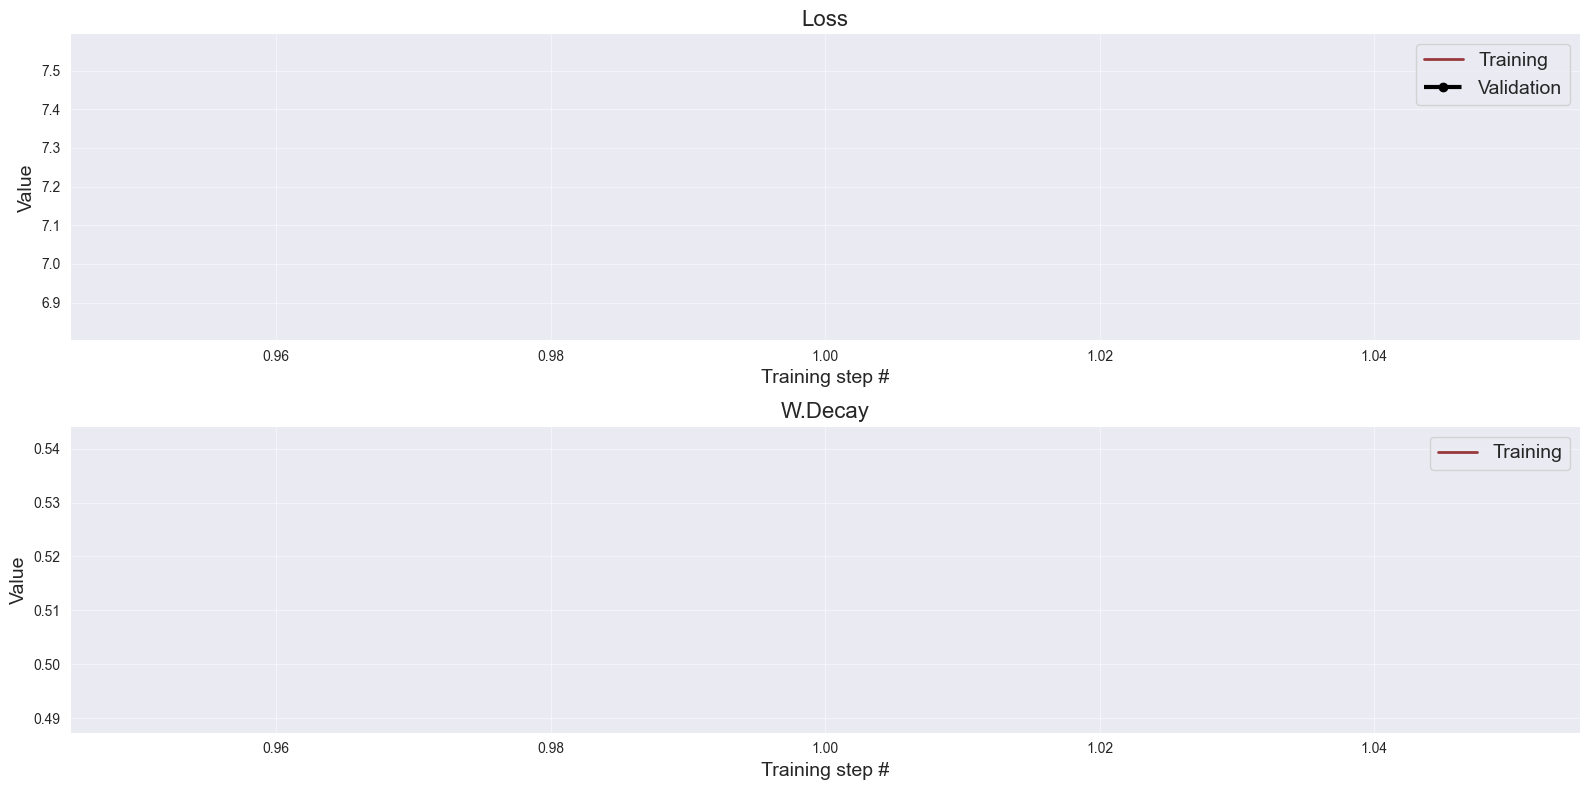

In [21]:
l = bf.diagnostics.plot_losses(train_losses=losses['train_losses'], val_losses=losses['val_losses'])